Use https://github.com/jfcrenshaw/auxtel_aos , in particular https://github.com/jfcrenshaw/auxtel_aos/blob/main/notebooks/example_auxtel_sim.ipynb
        
However, need to use perturbations defined by Zk coefficients - there's something similar here https://github.com/suberlak/AOS/blob/main/AOS_DM-34846_compensable.ipynb (although 

as well as https://github.com/jmeyers314/wfsim/blob/perturbations/notebooks/ts_wep%20demo%20on-axis.ipynb 



Need to first simulate the perturbations given Zernikes - 

In [2]:
!pip install galsim
!pip install danish
!pip install batoid

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for danish: filename=danish-0.1.5-cp310-cp310-linux_x86_64.whl size=66681 sha256=8f18336efd993e270e53c11ec7164279c4aae5f99925f351ac6f629ead8b4c72
  Stored in directory: /sdf/home/s/scichris/.cache/pip/wheels/63/61/3d/5106d716d7acc6dc27cd2868444a9b6a3c5c588def050c5ea9
Successfully built danish
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for batoid: filename=batoid-0.3.7-cp310-cp310-linux_x86_64.whl size=4604546 sha256=af15c3d62365f18a0761f0cab2cf7a7053ea38d3818b780d0d72f9c8fa9e4669
  Stored in directory: /sdf/home/

To get `wfsim` we can't just do `pip install` - that will pull a different `wfsim` (which has nothing to do with AOS). Instead, we need to do 


    git clone https://github.com/jmeyers314/wfsim.git

    cd wfsim 

    git lfs install

    git lfs pull

    python setup.py install --user  
    
    

In [3]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim



In [4]:
auxtel = batoid.Optic.fromYaml("AuxTel.yaml")

bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
seed = 0
rng = np.random.default_rng(seed)

# parameters associated with the observing conditions
obs_params = {
    # zenith=0 means straight up, while zenith=90 is the horizon
    # greater zenith angle means more atmospheric turbulence
    "zenith": 30 * galsim.degrees,

    # raw_seeing sets how much atmospheric turbulence there is at zenith=0
    # wfsim uses this to calculate how much turbulence there is at 
    # the zenith angle given above
    "raw_seeing": 0.7 * galsim.arcsec,

    # these next three parameters set attributes of the atmosphere, which
    # help determine how much turbulence there is
    "temperature": 293, # Kelvin
    "pressure": 69, # kPa
    "H2O_pressure": 1, # kPa

    # wavelength of the observed light. this is important because light of 
    # longer/shorter wavelength refracts less/more in the atmosphere
    "wavelength": bandpass.effective_wavelength, # nanometers

    # the AuxTel exposure time
    "exptime": 30, # seconds
}

# parameters associated with computational aspects of simulating the atmosphere
atm_params = {
    "screen_size": 819.2,
    "screen_scale": 0.1,
    "nproc": 6,
}

One way : try adding bending modes 


Question: 
* should I be applying these modes to "M2" (secondary) or "M1" (primary) in auxTel? (given the schematic in https://github.com/jfcrenshaw/auxtel_aos/blob/main/notebooks/example_auxtel_sim.ipynb ) 
* is there a way to supply a list of Zernikes ? 

In [6]:
# provide the modes as Zernikes 
M2_modes = rng.uniform(-1e-1, +1e-1, size=23) # waves
M2_modes *= bandpass.effective_wavelength * 1e-9 # meters

# Could I do something like 
#M2_modes = [50, 0,0,0,0,0,0,0,0,0] # nm 

M2_surface_perturbation = batoid.Zernike(
    M2_modes,
    R_outer=0.6
)

# we apply the same surface perturbations to the telescope
# whether intra or extra focal ... 
perturbed = auxtel.withSurface(
    "M2",
    batoid.Sum([
        auxtel["M2"].surface,
        M2_surface_perturbation,]))


# shift for defocal 
intra = perturbed.withGloballyShiftedOptic(
   "M2", [0, 0, -0.0008] 
)
extra = perturbed.withGloballyShiftedOptic(
   "M2", [0, 0, +0.0008] 
)

In [93]:
intra_simulator = wfsim.SimpleSimulator(
    obs_params,
    atm_params,
    intra,
    bandpass,
    shape=(4000, 4000),
    rng=rng
)

extra_simulator = wfsim.SimpleSimulator(
    obs_params,
    atm_params,
    extra,
    bandpass,
    shape=(4000, 4000),
    rng=rng
)

In [94]:
# choose a position for the star
# these angles specify the angle from the optical axis to the star
thx = np.deg2rad(0)
thy = np.deg2rad(0)

# create a spectrum for the star -- this is needed for chromatic refraction
# we will randomly select a plausible star temperature, 
# and calculate the corresponding blackbody spectrum
star_temp = rng.uniform(4_000, 10_000) # Kelvin
sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

# randomly choose a flux (must be an integer)
flux = rng.integers(1_000_000, 2_000_000)


intra_simulator.add_star(thx, thy, sed, flux, rng)
extra_simulator.add_star(thx, thy, sed, flux, rng)

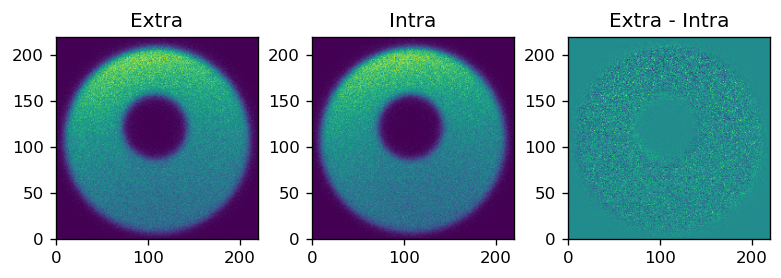

In [91]:
# seed =0 
xcen,ycen = 2120,1895

# seed =10 
dx,dy = 110,110
fig, axes = plt.subplots(1, 3, dpi=120, constrained_layout=True)

extra_stamp = extra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
intra_stamp = intra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
axes[0].imshow(extra_stamp, origin="lower")
axes[0].set_title("Extra",)# color="b")

axes[1].imshow(intra_stamp, origin="lower")
axes[1].set_title("Intra", )#color="b")

axes[2].imshow(extra_stamp-intra_stamp, origin="lower")
axes[2].set_title("Extra - Intra",)# color="w")

#for ax in axes:
#    ax.set(xticks=[], yticks=[])

plt.show()


In [ ]:
xcen,ycen = 1595,2000
dx,dy = 110,110
fig, axes = plt.subplots(1, 3, dpi=120, constrained_layout=True)

extra_stamp = extra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
intra_stamp = intra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
axes[0].imshow(extra_stamp, origin="lower")
axes[0].set_title("Extra",)# color="b")

axes[1].imshow(intra_stamp, origin="lower")
axes[1].set_title("Intra", )#color="b")

axes[2].imshow(extra_stamp-intra_stamp, origin="lower")
axes[2].set_title("Extra - Intra",)# color="w")

#for ax in axes:
#    ax.set(xticks=[], yticks=[])

plt.show()


What was the truth? 

In [144]:
# for auxtel
# inner_radius / outer_radius = 0.2538/0.6 # in meters 

# the fractional inner radius is 
inner_radius  = 0.2538 #  [m]
outer_radius = 0.6 # [m]
eps = inner_radius / outer_radius
eps

0.42300000000000004

In [145]:
wavelength  =  bandpass.effective_wavelength * 1e-9 # batoid wants meters 
zs = batoid.zernike(auxtel, thx, thy, wavelength, eps=eps)
zs*=wavelength  #  waves -> nm 

In [146]:
len(zs)

23

Text(0, 0.5, 'Zk [nm]')

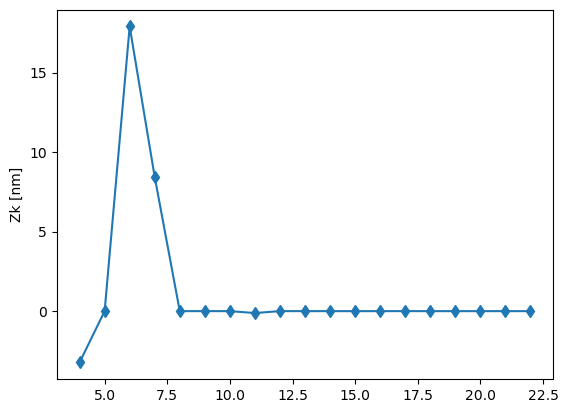

In [147]:
plt.plot(np.arange(4,23), zs[4:]*1e9,'-d')
plt.ylabel('Zk [nm]')

In [104]:
zs[4:]*1e9

array([-3.22728490e+00, -3.55000158e-15,  1.78933690e+01,  8.42954168e+00,
        7.26577753e-15,  4.33032629e-04, -1.84742021e-15, -1.19750172e-01,
        1.77579598e-03,  1.01950299e-15,  2.06400984e-07,  6.61910770e-15,
        4.98912994e-15,  8.69112836e-04,  7.01708985e-15,  5.62248823e-07,
        4.85798528e-15,  2.43578621e-07, -6.10464445e-04])

Try fitting with `ts_wep` : 

In [148]:
from lsst.ts.wep.Utility import (
    getConfigDir,
    DonutTemplateType,
    DefocalType,
    CamType,
    getCamType,
    getDefocalDisInMm,
    CentroidFindType
)
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage

fieldXY = np.zeros(2)

instName = 'auxTel'
opticalModel = 'onAxis'
sizeInPix = 220 # here we make bigger stamps than the usual 200  # donut stamp size 
suffix = 'auxTel'
configDir = getConfigDir()
algoDir = os.path.join(configDir, "cwfs", "algo")
tol=1e-3

# this is part of the init
inst = Instrument()
algo = Algorithm(algoDir)

# inside estimateZernikes()
camType = getCamType(instName)

# inside wfEsti.config
inst.configFromFile(sizeInPix, camType)

# choose the solver for the algorithm
solver = 'exp' # by default
debugLevel = 1 # 1 to 3
algo.config(solver, inst, debugLevel=debugLevel)

centroidFindType = CentroidFindType.RandomWalk
imgIntra = CompensableImage(centroidFindType=centroidFindType)
imgExtra = CompensableImage(centroidFindType=centroidFindType)

fieldXYIntra = fieldXY
fieldXYExtra = fieldXYIntra

# now inside  `wfEsti.setImg` method,
# which inherits from `CompensableImage`
imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image = extra_stamp)
#                image=rotate(donutExtra.stamp_im.getImage().getArray(), eulerZExtra).T)

imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image = intra_stamp)
#               image=rotate(donutIntra.stamp_im.getImage().getArray(), eulerZIntra).T)

boundaryT = algo.getBoundaryThickness()

# right after we set the image, the compensable image mask is empty -
# it is only calculated later in Algorithm
#maskScalingFactorLocal = 1

# algo, store = func.runIt_store(algo, imgIntra, imgExtra, model=opticalModel, 
#                           tol=1e-3,doCoCenter=doCoCenter)

# rename to just like it is in Algorithm.py
algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)

zer4UpInNm = algo.getZer4UpInNm()



# output from wep are in microns, need to convert to nm.
zern = [
    -zer4UpInNm[4] * 1e3,
    zer4UpInNm[3] * 1e3,
   zer4UpInNm[0] * 1e3,
]

In [22]:
np.shape(extra_stamp)[0]

220

In [130]:
zer4UpInNm

array([ 3.16361673, -2.31986299,  6.35454492, 10.61313301, -0.16735396,
        0.39889892,  0.92793016, -0.23343752, -0.17891586,  0.19113123,
       -3.22045819, -0.36602907, -0.28851364, -1.80955657, -0.03775103,
       -0.41575654,  0.70291157,  1.65599527,  0.09647041])

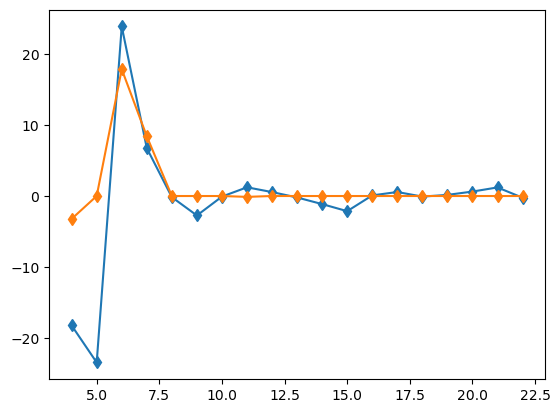

In [149]:
plt.plot(np.arange(4,23), zer4UpInNm, '-d', label='ts_wep')
plt.plot(np.arange(4,23), zs[4:]*1e9,'-d', label='truth')
plt.legend()

I'm not sure if that's the correct fit ... Why is it so far off ? 

Wrap the same but starting from different seed each time. Store the intra/extra images,  the zk "truth", and the zk "fit".

In [57]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim


from lsst.ts.wep.Utility import (
getConfigDir,
DonutTemplateType,
DefocalType,
CamType,
getCamType,
getDefocalDisInMm,
CentroidFindType
)
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage


auxtel = batoid.Optic.fromYaml("AuxTel.yaml")

bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')

# parameters associated with the observing conditions
obs_params = {
    # zenith=0 means straight up, while zenith=90 is the horizon
    # greater zenith angle means more atmospheric turbulence
    "zenith": 30 * galsim.degrees,

    # raw_seeing sets how much atmospheric turbulence there is at zenith=0
    # wfsim uses this to calculate how much turbulence there is at 
    # the zenith angle given above
    "raw_seeing": 0.7 * galsim.arcsec,

    # these next three parameters set attributes of the atmosphere, which
    # help determine how much turbulence there is
    "temperature": 293, # Kelvin
    "pressure": 69, # kPa
    "H2O_pressure": 1, # kPa

    # wavelength of the observed light. this is important because light of 
    # longer/shorter wavelength refracts less/more in the atmosphere
    "wavelength": bandpass.effective_wavelength, # nanometers

    # the AuxTel exposure time
    "exptime": 30, # seconds
}

# parameters associated with computational aspects of simulating the atmosphere
atm_params = {
    "screen_size": 819.2,
    "screen_scale": 0.1,
    "nproc": 6,
}

def simulate_batoid_and_fit_wep(seed, bandpass, batoid , obs_params,
                            atm_params,
                           ):
    rng = np.random.default_rng(seed)

    
    # provide the modes as Zernikes 
    M2_modes = rng.uniform(-3e-1, +3e-1, size=23) # waves
    M2_modes *= bandpass.effective_wavelength * 1e-9 # meters


    inner_radius  = 0.2538 #  [m]
    outer_radius = 0.635 # [m]


    M2_surface_perturbation = batoid.Zernike(
        M2_modes,
        R_outer=outer_radius  # XXX <-- is this correct for auxTel ? 
    ) # here it's 0.635
    # https://github.com/jmeyers314/danish/blob/main/notebooks/Danish%20vs%20Simulation%20AuxTel.ipynb
    # but 

    # we apply the same surface perturbations to the telescope
    # whether intra or extra focal ... 
    perturbed = auxtel.withSurface("M2", 
                                   batoid.Sum([auxtel["M2"].surface, 
                                   M2_surface_perturbation,])
                              )
    # shift M2 , 
    # as here https://github.com/lsst-ts/ts_wep/blob/2b89691fe6a712683d29c57739f29a999d58dda0/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml#L14-L17 
    # Move the M2 to fake the move of focal plane dz
    # Move the M2 by 0.8 mm = move the focal plane by 32.8 mm  (magnification of 41)
    # Defocal distance offset in mm
    intra = perturbed.withGloballyShiftedOptic("M2", [0, 0, -0.0008])
    extra = perturbed.withGloballyShiftedOptic("M2", [0, 0, +0.0008])

     
    # start the simulator 
    intra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        intra,
        bandpass,
        shape=(4000, 4000),
        rng=rng
    )

    extra_simulator = wfsim.SimpleSimulator(
        obs_params,
        atm_params,
        extra,
        bandpass,
        shape=(4000, 4000),
        rng=rng
    )
    
    # choose a position for the star
    # these angles specify the angle from the optical axis to the star
    thx = np.deg2rad(0)
    thy = np.deg2rad(0)

    # create a spectrum for the star -- this is needed for chromatic refraction
    # we will randomly select a plausible star temperature, 
    # and calculate the corresponding blackbody spectrum
    star_temp = rng.uniform(4_000, 10_000) # Kelvin
    sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

    # randomly choose a flux (must be an integer)
    flux = rng.integers(1_000_000, 2_000_000)
    
    intra_simulator.add_star(thx, thy, sed, flux, rng)
    extra_simulator.add_star(thx, thy, sed, flux, rng)


    # cut the stamp in a very manual and non-reproducible fashion 
    # since I only simulate one star here ...
    xcen,ycen = 1595,2000
    dx,dy = 110,110

    extra_stamp = extra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
    intra_stamp = intra_simulator.image.array[xcen-dx:xcen+dx, ycen-dy:ycen+dy]
    
    # the fractional inner radius is 
    eps = inner_radius / outer_radius
    
    # store the "truth" and the intra/extra images
    wavelength  =  bandpass.effective_wavelength * 1e-9 # batoid wants meters 
    zs = batoid.zernike(auxtel, thx, thy, wavelength, eps=eps)
    zs*=wavelength  #  waves -> nm 
    
    
    fname = f"auxtel_1_seed{seed}_stamps_truth.npz"
    print(f'saved {fname}')
    fpath = os.path.join('DM-37396',fname)
    np.savez(fpath,
    intra=intra_simulator.image.array,
    extra=extra_simulator.image.array,
    zktruth=zs)
    
    # run the ts_wep fit 
    fieldXY = np.zeros(2)
    instName = 'auxTel'
    opticalModel = 'onAxis'
    sizeInPix = np.shape(extra_stamp)[0] # here we make bigger stamps than the usual 200 
    suffix = 'auxTel'
    configDir = getConfigDir()
    algoDir = os.path.join(configDir, "cwfs", "algo")
    tol=1e-3

    # this is part of the init
    inst = Instrument()
    algo = Algorithm(algoDir)

    # inside estimateZernikes()
    camType = getCamType(instName)

    # inside wfEsti.config
    inst.configFromFile(sizeInPix, camType)

    # choose the solver for the algorithm
    solver = 'exp' # by default
    debugLevel = 1 # 1 to 3
    algo.config(solver, inst, debugLevel=debugLevel)

    centroidFindType = CentroidFindType.RandomWalk
    imgIntra = CompensableImage(centroidFindType=centroidFindType)
    imgExtra = CompensableImage(centroidFindType=centroidFindType)

    fieldXYIntra = fieldXY
    fieldXYExtra = fieldXYIntra

    # now inside  `wfEsti.setImg` method
    imgExtra.setImg(fieldXYExtra,
                DefocalType.Extra,
                image = extra_stamp)

    imgIntra.setImg(fieldXYIntra,
                DefocalType.Intra,
                image = intra_stamp)
    
    algo.runIt(imgIntra, imgExtra, opticalModel, tol=tol)

    zer4UpInNm = algo.getZer4UpInNm()
    
    
    # save the ts_wep fit results
    fname = f"auxtel_1_seed{seed}_ts_wep_fit.npz"
    print(f'saved {fname}')
    fpath = os.path.join('DM-37396',fname)
    np.savez(fpath, zkfit=zer4UpInNm)
    
    
    # run the CWFS fit : next

In [58]:
for seed in np.random.randint(0,100,5):
    simulate_batoid_and_fit_wep(seed,bandpass, batoid , obs_params,
                            atm_params)

saved auxtel_1_seed98_stamps_truth.npz
saved auxtel_1_seed98_ts_wep_fit.npz
saved auxtel_1_seed9_stamps_truth.npz
saved auxtel_1_seed9_ts_wep_fit.npz
saved auxtel_1_seed52_stamps_truth.npz
saved auxtel_1_seed52_ts_wep_fit.npz
saved auxtel_1_seed70_stamps_truth.npz
saved auxtel_1_seed70_ts_wep_fit.npz
saved auxtel_1_seed10_stamps_truth.npz
saved auxtel_1_seed10_ts_wep_fit.npz


In [59]:
# run the CWFS fit ...
from lsst import cwfs
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image
from lsst.cwfs.instrument import Instrument
from pathlib import Path

_dz =  0.8 # ???  # There is  "defocal offset" with a value of 32.8 mm  from https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml
# this value is in the latiss_base_align.py
# if I set _dz = 0.8, then   0.8*0.041  = 32.8 * 1e-3 , i.e. same as in ts_wep config ....
binning = 1  
side = 110  #  https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/tests/auxtel/test_latiss_cwfs_align.py#L525
# from https://github.com/lsst-ts/ts_externalscripts/blob/8ba110cd64a134bf7d4efca424477c26deec96eb/python/lsst/ts/externalscripts/auxtel/latiss_base_align.py#L169
    
#0.0205

# Create configuration file with the proper parameters
cwfs_config_template = """#Auxiliary Telescope parameters:
Obscuration 				0.423
Focal_length (m)			21.6
Aperture_diameter (m)   		1.2
Offset (m)				{}
Pixel_size (m)			{}
"""
config_index = "auxtel_latiss"
path = Path(cwfs.__file__).resolve().parents[3].joinpath("data", config_index)
print(path)
if not path.exists():
    os.makedirs(path)
dest = path.joinpath(f"{config_index}.param")
with open(dest, "w") as fp:
    # Write the file and set the offset and pixel size parameters
    fp.write(
        cwfs_config_template.format(_dz * 0.041, 10e-6 *binning)
    )

inst = Instrument(config_index, int(side * 2 / binning))
algo = Algorithm("exp", inst, 1)

fieldXY = [0.0, 0.0]


# load the stamps
for seed in [98,9,52, 70,10]:
    fname = f"auxtel_1_seed{seed}_stamps_truth.npz"
    print(f'loaded image from {fname}')
    fpath = os.path.join('DM-37396',fname)
    npz = np.load(fpath)
    intra_image = npz['intra']
    extra_image = npz['extra']

    # cutout stamp from image 
    xcen,ycen = 1595,2000
    dx,dy = 110,110
    intra_stamp = intra_image[xcen-dx:xcen+dx, ycen-dy:ycen+dy] 
    extra_stamp = extra_image[xcen-dx:xcen+dx, ycen-dy:ycen+dy]

    I1 = Image(intra_stamp, fieldXY, Image.INTRA)
    I2 = Image(extra_stamp, fieldXY, Image.EXTRA)


    algo.reset(I1,I2)
    algo.runIt(inst, I1, I2, "paraxial")
    zer4UpNm = algo.zer4UpNm


    # save the ts_wep fit results
    fname = f"auxtel_1_seed{seed}_cwfs_fit.npz"
    print(f'saved {fname}')
    fpath = os.path.join('DM-37396',fname)
    np.savez(fpath, zkfit=zer4UpNm)


/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/cwfs/data/auxtel_latiss
loaded image from auxtel_1_seed98_stamps_truth.npz
saved auxtel_1_seed98_cwfs_fit.npz
loaded image from auxtel_1_seed9_stamps_truth.npz
saved auxtel_1_seed9_cwfs_fit.npz
loaded image from auxtel_1_seed52_stamps_truth.npz
saved auxtel_1_seed52_cwfs_fit.npz
loaded image from auxtel_1_seed70_stamps_truth.npz
saved auxtel_1_seed70_cwfs_fit.npz
loaded image from auxtel_1_seed10_stamps_truth.npz
saved auxtel_1_seed10_cwfs_fit.npz


First I simulated 

     M2_modes = rng.uniform(-1e-1, +1e-1, size=23) # waves
(that's `auxtel_seedNN_stamps_truth.npz)`
 
but then I bumped it up to 

    M2_modes = rng.uniform(-3e-1, +3e-1, size=23) # waves


because it seemed that the only Zk that gets excited at all is Zk6, to a very small degree (just tens of nm...)
(that's `auxtel_1_seedNN_stamps_truth.npz)`



loaded truth from auxtel_seed98_stamps_truth.npz
loaded ts_wep from auxtel_seed98_ts_wep_fit.npz
loaded cwfs from auxtel_seed98_cwfs_fit.npz
loaded truth from auxtel_seed12_stamps_truth.npz
loaded ts_wep from auxtel_seed12_ts_wep_fit.npz
loaded cwfs from auxtel_seed12_cwfs_fit.npz
loaded truth from auxtel_seed25_stamps_truth.npz
loaded ts_wep from auxtel_seed25_ts_wep_fit.npz
loaded cwfs from auxtel_seed25_cwfs_fit.npz
loaded truth from auxtel_seed60_stamps_truth.npz
loaded ts_wep from auxtel_seed60_ts_wep_fit.npz
loaded cwfs from auxtel_seed60_cwfs_fit.npz


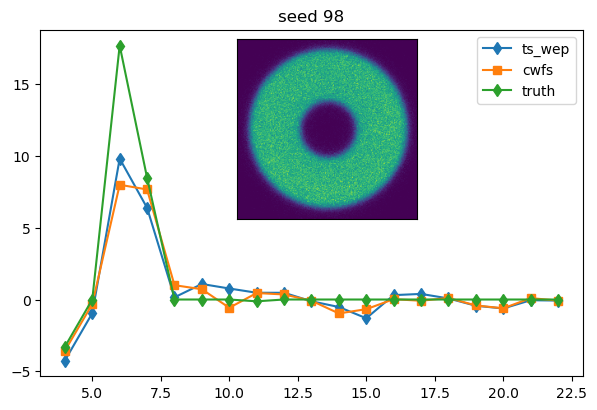

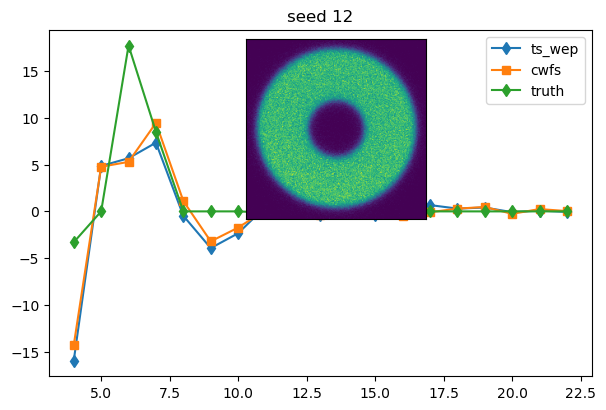

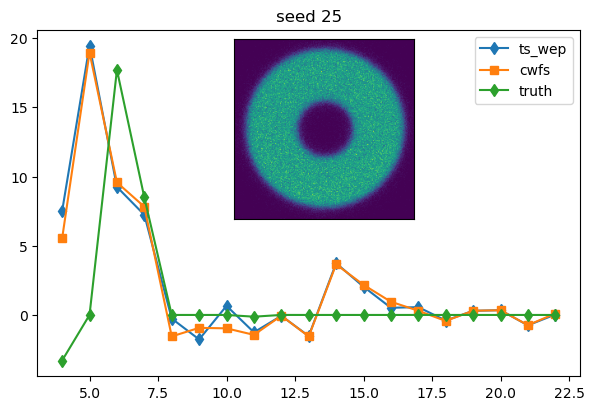

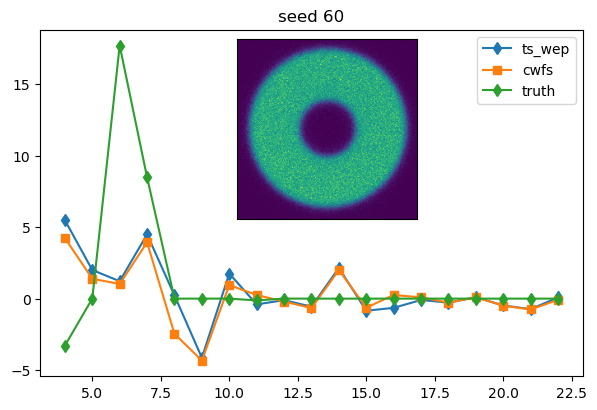

In [55]:
for seed in [98,12,25,60]:
#seed=98 
    # load truth 
    fname = f"auxtel_seed{seed}_stamps_truth.npz"
    print(f'loaded truth from {fname}')
    fpath = os.path.join('DM-37396',fname)
    npz = np.load(fpath)
    zk_truth = npz['zktruth']
    xcen,ycen = 1595,2000
    dx,dy = 110,110
    intra_image = npz['intra']
    intra_stamp = intra_image[xcen-dx:xcen+dx, ycen-dy:ycen+dy] 

    # load ts_wep result
    # save the ts_wep fit results
    fname = f"auxtel_seed{seed}_ts_wep_fit.npz"
    print(f'loaded ts_wep from {fname}')
    fpath = os.path.join('DM-37396',fname)
    npz = np.load(fpath)
    zk_wep = npz['zkfit']  # Zk4UpInNm

    # load cwfs result 
    fname = f"auxtel_seed{seed}_cwfs_fit.npz"
    print(f'loaded cwfs from {fname}')
    fpath = os.path.join('DM-37396',fname)
    npz = np.load(fpath)
    zk_cwfs = npz['zkfit'] # zk4UpInNm

    fig,ax = plt.subplots(1,1,figsize=(7,4.5))
    ax.set_title(f'seed {seed}')
    ax.plot(np.arange(4,23), zk_wep, '-d', label='ts_wep')
    ax.plot(np.arange(4,23), zk_cwfs, '-s', label='cwfs')
    ax.plot(np.arange(4,23), zk_truth[4:]*1e9,'-d', label='truth')
    ax.legend()

    ax1 = fig.add_axes([0.4,0.46,0.27,0.4])
    ax1.set(xticks=[], yticks=[])
    ax1.imshow(intra_stamp)

Exctiting M2 more (using `rng.uniform(-3e-1, +3e-1, size=23)`) : 

loaded truth from auxtel_1_seed98_stamps_truth.npz
loaded ts_wep from auxtel_1_seed98_ts_wep_fit.npz
loaded cwfs from auxtel_1_seed98_cwfs_fit.npz
loaded truth from auxtel_1_seed9_stamps_truth.npz
loaded ts_wep from auxtel_1_seed9_ts_wep_fit.npz
loaded cwfs from auxtel_1_seed9_cwfs_fit.npz
loaded truth from auxtel_1_seed52_stamps_truth.npz
loaded ts_wep from auxtel_1_seed52_ts_wep_fit.npz
loaded cwfs from auxtel_1_seed52_cwfs_fit.npz
loaded truth from auxtel_1_seed70_stamps_truth.npz
loaded ts_wep from auxtel_1_seed70_ts_wep_fit.npz
loaded cwfs from auxtel_1_seed70_cwfs_fit.npz
loaded truth from auxtel_1_seed10_stamps_truth.npz
loaded ts_wep from auxtel_1_seed10_ts_wep_fit.npz
loaded cwfs from auxtel_1_seed10_cwfs_fit.npz


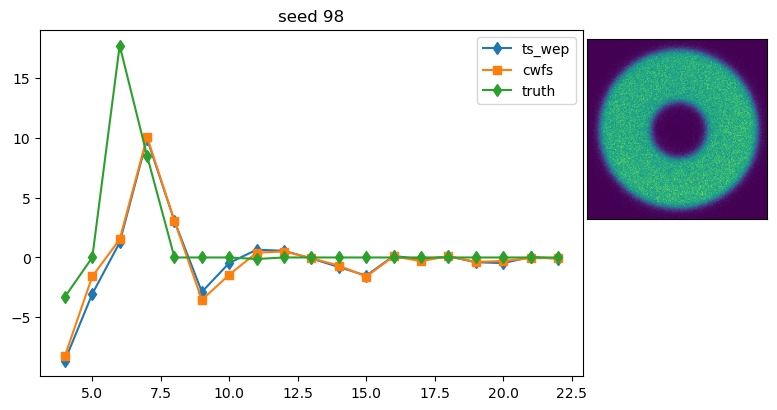

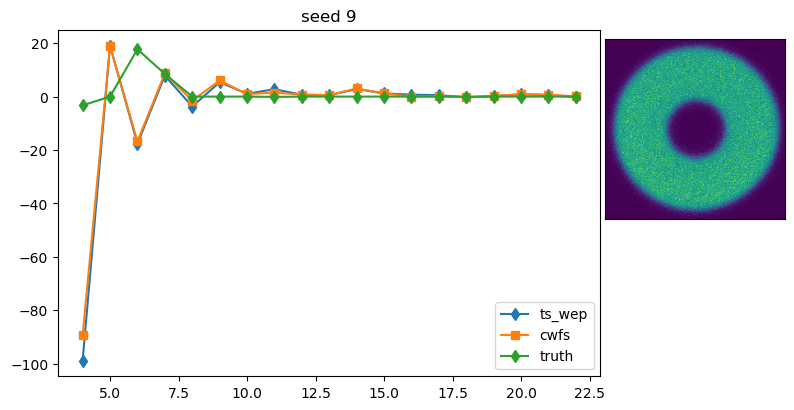

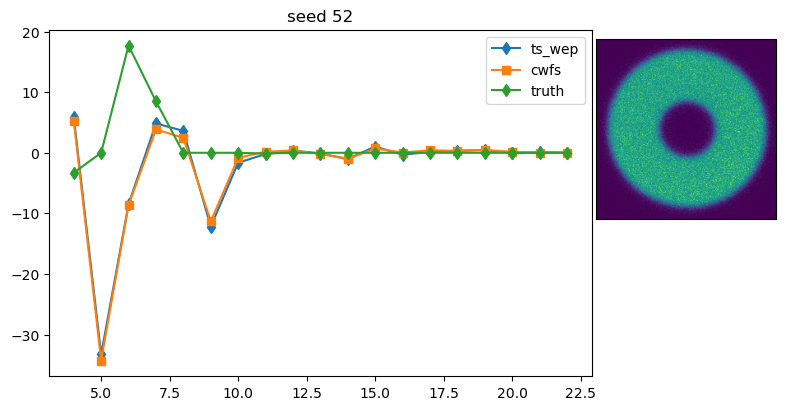

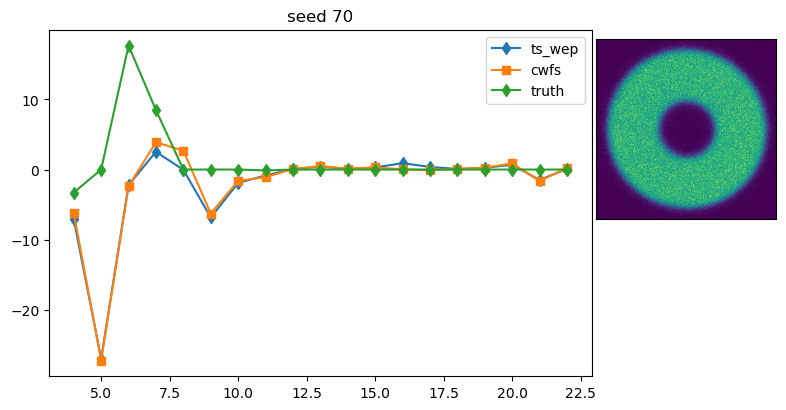

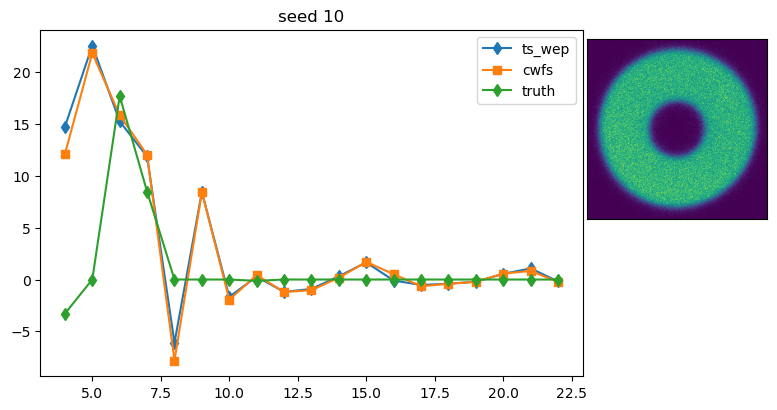

In [62]:
for seed in [98,9,52, 70,10]:
             
    # load truth 
    fname = f"auxtel_1_seed{seed}_stamps_truth.npz"
    print(f'loaded truth from {fname}')
    fpath = os.path.join('DM-37396',fname)
    npz = np.load(fpath)
    zk_truth = npz['zktruth']
    xcen,ycen = 1595,2000
    dx,dy = 110,110
    intra_image = npz['intra']
    intra_stamp = intra_image[xcen-dx:xcen+dx, ycen-dy:ycen+dy] 

    # load ts_wep result
    # save the ts_wep fit results
    fname = f"auxtel_1_seed{seed}_ts_wep_fit.npz"
    print(f'loaded ts_wep from {fname}')
    fpath = os.path.join('DM-37396',fname)
    npz = np.load(fpath)
    zk_wep = npz['zkfit']  # Zk4UpInNm

    # load cwfs result 
    fname = f"auxtel_1_seed{seed}_cwfs_fit.npz"
    print(f'loaded cwfs from {fname}')
    fpath = os.path.join('DM-37396',fname)
    npz = np.load(fpath)
    zk_cwfs = npz['zkfit'] # zk4UpInNm

    fig,ax = plt.subplots(1,1,figsize=(7,4.5))
    ax.set_title(f'seed {seed}')
    ax.plot(np.arange(4,23), zk_wep, '-d', label='ts_wep')
    ax.plot(np.arange(4,23), zk_cwfs, '-s', label='cwfs')
    ax.plot(np.arange(4,23), zk_truth[4:]*1e9,'-d', label='truth')
    ax.legend()

    ax1 = fig.add_axes([0.9,0.46,0.27,0.4])
    ax1.set(xticks=[], yticks=[])
    ax1.imshow(intra_stamp)

## [Aside]: use x,y,z-offsets & rotation
    
    
    * backburner because it creates donuts at different locations, so would need to run donut detection at each stage  --> create an exposure and feed it to eg. `afwDetect` 

In [ ]:
import numpy as np # standard package for doing calculations
import matplotlib.pyplot as plt # standard package for plotting

import batoid
import galsim

import sys
sys.path.append('/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/wfsim/')
import wfsim


auxtel = batoid.Optic.fromYaml("AuxTel.yaml")
bandpass = galsim.Bandpass("LSST_r.dat", wave_type='nm')


# parameters associated with the observing conditions
obs_params = {
    # zenith=0 means straight up, while zenith=90 is the horizon
    # greater zenith angle means more atmospheric turbulence
    "zenith": 30 * galsim.degrees,

    # raw_seeing sets how much atmospheric turbulence there is at zenith=0
    # wfsim uses this to calculate how much turbulence there is at 
    # the zenith angle given above
    "raw_seeing": 0.7 * galsim.arcsec,

    # these next three parameters set attributes of the atmosphere, which
    # help determine how much turbulence there is
    "temperature": 293, # Kelvin
    "pressure": 69, # kPa
    "H2O_pressure": 1, # kPa

    # wavelength of the observed light. this is important because light of 
    # longer/shorter wavelength refracts less/more in the atmosphere
    "wavelength": bandpass.effective_wavelength, # nanometers

    # the AuxTel exposure time
    "exptime": 30, # seconds
}

# parameters associated with computational aspects of simulating the atmosphere
atm_params = {
    "screen_size": 819.2,
    "screen_scale": 0.1,
    "nproc": 6,
}


seed = 0
rng = np.random.default_rng(seed)


M2_trans_intra = np.array([
        rng.uniform(-0.001, 0.001),  # meters
        rng.uniform(-0.001, 0.001),
        rng.uniform(-0.0001, 0.0001)- 0.0008,
    ])

M2_trans_extra = np.array([
        rng.uniform(-0.001, 0.001),  # meters
        rng.uniform(-0.001, 0.001),
        rng.uniform(-0.0001, 0.0001)+ 0.0008,
    ])

# now lets's select some random rotations
M2_rot = (
    batoid.RotX(np.deg2rad(rng.uniform(-0.1, 0.1)/60)) @
    batoid.RotY(np.deg2rad(rng.uniform(-0.1, 0.1)/60))
)

# now let's create a copy of the AuxTel with these perturbations
intra = (
    auxtel
    .withGloballyShiftedOptic("M2", M2_trans_intra)
    .withLocallyRotatedOptic("M2", M2_rot)
)

extra =  (
    auxtel
    .withGloballyShiftedOptic("M2", M2_trans_intra)
    .withLocallyRotatedOptic("M2", M2_rot)
)


intra_simulator = wfsim.SimpleSimulator(
    obs_params,
    atm_params,
    intra,
    bandpass,
    shape=(4000, 4000),
    rng=rng
)

extra_simulator = wfsim.SimpleSimulator(
    obs_params,
    atm_params,
    extra,
    bandpass,
    shape=(4000, 4000),
    rng=rng
)

# choose a position for the star
# these angles specify the angle from the optical axis to the star
thx = np.deg2rad(0)
thy = np.deg2rad(0)

# create a spectrum for the star -- this is needed for chromatic refraction
# we will randomly select a plausible star temperature, 
# and calculate the corresponding blackbody spectrum
star_temp = rng.uniform(4_000, 10_000) # Kelvin
sed = wfsim.BBSED(star_temp) # wfsim has a function to calculate the blackbody spectrum

# randomly choose a flux (must be an integer)
flux = rng.integers(1_000_000, 2_000_000)


intra_simulator.add_star(thx, thy, sed, flux, rng)
extra_simulator.add_star(thx, thy, sed, flux, rng)

# seed = 0
plt.imshow(intra_simulator.image.array, origin='lower')